# Let's get it!!!
In the begining, off course, the packages that I need should be imported properly. Almost every package imported is followed a remark that explains the purpose. Hope that it is very easy to read and that it helps anyone who check this kernel understand my codes :)

In [1]:
# import those packages that I need
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # to see the running process
from skimage.io import imread, imshow # to read the image from workspace
from skimage.transform import resize # resize those data to a certain size for training
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
import os
import keras 
from keras.utils.np_utils import to_categorical # for One-Hot Encoding
from sklearn.model_selection import train_test_split # for generating validation set (X_val, Y_val)

from keras.applications.resnet50 import ResNet50 # the well-known CNN model imported for transfer learning
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau # built-in callbacks in keras 
from keras.preprocessing.image import ImageDataGenerator # for data augmentation
from keras import backend as K
from keras.optimizers import Adam # the model optimizer that I choose for this task
from keras.regularizers import l1,l2 # L1, L2 regularization to avoid overfitting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import itertools

# the following remark(code) can be used to see all the files in the 'input' folder in the Workspace

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Load training and testing data!!!

The most important thing in supervised learning is the labeled data for training. Those images that feature either dogs or cats are located in the Workspace. So, to load them into this kernel, let's build functions for the training data and testing data. 

In [2]:
# function for loading training images and labeling them in the same time according to which folder they come from, 'dogs' or 'cats'

def read_image_train(folder,resize_hight = 224, resize_width = 224):
    
    DATA_ROOT = "../input/"
    dogs = np.ones((1,resize_hight,resize_width,3))
    cats = np.ones((1,resize_hight,resize_width,3))
    
    dogs_label=[]
    cats_label=[]
    
    for image_type in os.listdir(folder):
        # print(image_type)
        if image_type == 'dogs':
            for image_name in tqdm(os.listdir(folder + '/' + image_type)):
                # print(image_name)
                im = imread(os.path.join(DATA_ROOT,folder + '/' + image_type + '/' + image_name))
                # print(im.shape)
                dog_size = im.size
#                 if dog_size >= (resize_hight*resize_width):
                if dog_size >= 0:
                    im_resized = resize(im, (resize_hight, resize_width), anti_aliasing=True)
                    im_resized = im_resized[np.newaxis,:,:,:]
                    # print(im_resized.shape)
                    dogs = np.concatenate((dogs,im_resized),axis=0)
                    dogs_label.append(0)
                    
        elif image_type == 'cats':
            for image_name in tqdm(os.listdir(folder +'/'+ image_type)):
                # print(image_name)
                im = imread(os.path.join(DATA_ROOT,folder + '/' +image_type + '/' +image_name))
                # print(im.shape)
                cat_size = im.size
#                 if cat_size >= (resize_hight*resize_width):
                if cat_size >= 0:
                    im_resized = resize(im, (resize_hight, resize_width), anti_aliasing=True)
                    im_resized = im_resized[np.newaxis,:,:,:]
                    # print(im_resized.shape)
                    cats = np.concatenate((cats,im_resized),axis=0)
                    cats_label.append(1)
                    
    dogs = np.delete(dogs,(0),axis=0)
    cats = np.delete(cats,(0),axis=0)
    image_array = np.concatenate((dogs,cats),axis = 0)
    print(image_array.shape)

    dogs_label = np.asarray(dogs_label)
    cats_label = np.asarray(cats_label)
    label = np.concatenate((dogs_label,cats_label),axis=0)
    print(label.shape)
    
    return image_array, label

In [3]:
# function for loading the testing data and getting their ID at the same time
# the reason that getting the ID is for the submission csv file because the probability of class should match the image name

def read_image_test(folder,resize_hight = 224, resize_width = 224):
    
    DATA_ROOT = "../input/"
    img = np.ones((1,resize_hight,resize_width,3))
    names = []
    
    for image_name in tqdm(os.listdir(folder)):
        # print(image_name)
        im = imread(os.path.join(DATA_ROOT,folder + '/' + image_name))
        # print(im.shape)
        
        im_resized = resize(im, (resize_hight, resize_width), anti_aliasing=True)
        im_resized = im_resized[np.newaxis,:,:,:]
        # print(im_resized.shape)
        img = np.concatenate((img,im_resized),axis=0)
        name_split = image_name.split('.')
        names.append(name_split[0])

                    
    img = np.delete(img,(0),axis=0)
    names = np.asarray(names)
    print("The shape of image",img.shape)
    print("The shape of image name :", names.shape)
    
    return img , names

In [4]:
# Now, We are able to load those data that we need for this task.
# loading images and transform them into numpy array with labels (cats: 1,dogs:0)

x_train, y_train = read_image_train('/kaggle/input/ml-marathon-final/data/kaggle_dogcat/train')
x_test, names = read_image_test('/kaggle/input/ml-marathon-final/data/kaggle_dogcat/test')

  2%|▏         | 9/400 [00:00<00:04, 86.86it/s]

(4000, 224, 224, 3)
(4000,)


100%|██████████| 400/400 [01:16<00:00,  2.74it/s]


The shape of image (400, 224, 224, 3)
The shape of image name : (400,)


# Preprocessing
For every image, the range of pixel values varies. So if the image data isn't preprocessed, it may influence the training result. One of the most common ways of preprocessing is normalization. Other ways like histogram matching, gamma correction are worth trying as well. But for this case, I choose simple normalization to preprocess those image data. Hope that it works!!!

In [5]:
# normalization
x_train = x_train.astype('float32')
# x_train /= 255
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_train -= x_train_mean
x_train /= x_train_std

x_test = x_test.astype('float32')
# x_test /= 255
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_test -= x_test_mean
x_test /= x_test_std

# label : one-hot encoding 
num_class = 2
y_trainHOT = keras.utils.to_categorical(y_train, num_class)

# extract 1/4 training data as validation data
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_trainHOT, test_size=0.25, random_state=42)

# print out the shape of images and labels
print("The shape of x_train: ",X_train.shape)
print("The shape of y_train: ",Y_train.shape)
print("The shape of x_val: ",X_val.shape)
print("The shape of y_val: ",Y_val.shape)

print("The shape of x_test: ",x_test.shape)

The shape of x_train:  (3000, 224, 224, 3)
The shape of y_train:  (3000, 2)
The shape of x_val:  (1000, 224, 224, 3)
The shape of y_val:  (1000, 2)
The shape of x_test:  (400, 224, 224, 3)


In [6]:
# hyperparameters
resize_hight = 224
resize_width = 224
NUM_CLASSES = 2
batch_size = 4  
epochs = 50
learning_rate = 1e-5
aug = False
initial_train = True

# Transfer Learning: ResNet50
Due to my desperate attempt to use a simple CNN model for this task, which the accuracy and the ROC-AUC value is very low, I gave up on trying to build a descent and simple CNN model on my own. Taking ResNet50 model's extrodinary performance on image classification, I build a model based on it (Transfer Learning) and load the pretrained weight that is pretrained on ImageNet dataset. "'include_top' = False" means that the last fully-connected layer will be removed, so we should add our fully-connected layer to complete the ResNet50-based CNN model.

In [7]:
# construct the ResNet50 from keras.applications.resnet50 (the packages that i import above!)
ResNet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(resize_hight,resize_width,3))

x = ResNet50_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
ResNet50_model_final = Model(inputs=ResNet50_model.input, outputs=output_layer)

ResNet50_model_final.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_model_final.summary()

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

In [8]:
# Data augmentation: Although I may not use it, it is worth trying :)
train_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

# callbacks
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=9, 
                              verbose=1)

earlystop = EarlyStopping(monitor="val_acc", 
                          patience=5, 
                          verbose=1)

# save the model for future usage
model_save='model_shuffle_noAug_allimage_bs4.h5' 
model_checkpoint = ModelCheckpoint(filepath=model_save, 
                                   monitor="val_loss", 
                                   save_best_only=True)

In [9]:
# training
if initial_train == True:
    if aug == True:
        train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size,shuffle=False)
        validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size,shuffle=False)
    
        history = ResNet50_model_final.fit_generator(train_generator,
                                steps_per_epoch=len(X_train) // batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=validation_generator,
                                validation_steps = len(X_val) // batch_size,
                                shuffle=True,
                                callbacks = [model_checkpoint,earlystop,reduce_lr])
    else:
        history = ResNet50_model_final.fit(X_train,Y_train,
                                batch_size = batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data= (X_val,Y_val),
                                shuffle=True,
                                callbacks = [model_checkpoint,earlystop,reduce_lr])


    # Collect results
    train_loss = ResNet50_model_final.history.history["loss"]
    valid_loss = ResNet50_model_final.history.history["val_loss"]
    train_acc = ResNet50_model_final.history.history["acc"]
    valid_acc = ResNet50_model_final.history.history["val_acc"]

else:
    ResNet50_model_final = keras.models.load_model("/kaggle/input/cats-dogsclassification/model_shuffle_noAug_allimage.h5")
    
score = ResNet50_model_final.evaluate(X_val,Y_val)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 89s 30ms/step - loss: 0.5863 - acc: 0.8120 - val_loss: 0.2603 - val_acc: 0.9340
Epoch 2/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.1973 - acc: 0.9367 - val_loss: 0.1707 - val_acc: 0.9500
Epoch 3/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.1072 - acc: 0.9603 - val_loss: 0.1616 - val_acc: 0.9590
Epoch 4/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.0772 - acc: 0.9743 - val_loss: 0.1326 - val_acc: 0.9580
Epoch 5/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.0423 - acc: 0.9853 - val_loss: 0.1309 - val_acc: 0.9590
Epoch 6/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.0390 - acc: 0.9880 - val_loss: 0.1277 - val_acc: 0.9640
Epoch 7/50
3000/3000 [==============================] - 75s 25ms/step - loss: 0.0234 - acc: 0.9913 - val_loss: 0.1354 - val_acc: 0.9580


# Plot the result !!!
After training several epochs, let's check our model's performance. Following is loss and accuracy of training set and validation set during each epoch. I also plot a ROC curve and calculate the area under curve (AUC value) to evaluate the model. Lastly, I also plot a  confusion matrix to check the model performance as well.

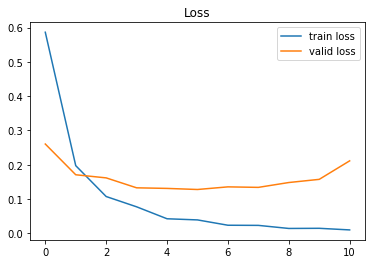

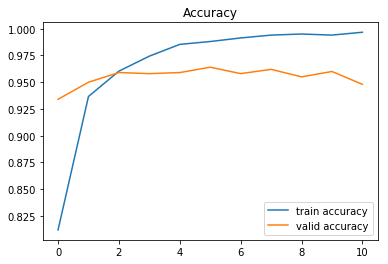

In [10]:
# plot the accuracy and loss during every epoch

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [11]:
# functin that plot the confusion matrix, helping understand the performance of the model
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm=(cm*100+.01).astype(int)/100

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

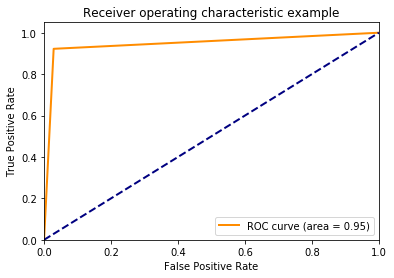

In [12]:
# to plot the ROC curve to see the performance of our model

Y_val_roc = np.argmax(Y_val,axis=1) # ground truth
# ResNet50_model_final = keras.models.load_model("/kaggle/input/cats-dogsclassification/model_noshuffle_noAug_allimage.h5")
y_probas = ResNet50_model_final.predict(X_val) # prediction (probability)
Y_pred_classes = np.argmax(y_probas,axis=1) 
fpr, tpr, _ = roc_curve(Y_val_roc,Y_pred_classes)
roc_auc = auc(fpr, tpr)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

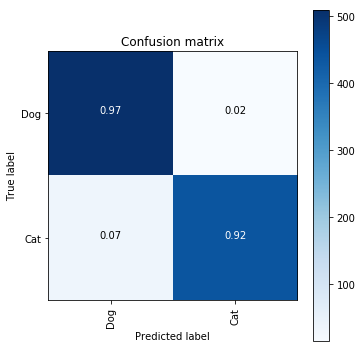

In [13]:
# plot the confusion matrix
dict_characters = {0:'Dog',1:'Cat'}
confusion_mtx = confusion_matrix(Y_val_roc, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes =list(dict_characters.values()))
plt.show()

# Let's make prediction on testing image!!!
It seems that our ResNet50 CNN model is quite good. So, let's move to our last and the most important step: Prediction. After we get the probability of class of each image, it is necessary to form a csv file that has the same format as the sample_submission.csv file. So I will read the sample_submission.csv file as my format and write my result (prediction on testing image) into this file.

In [14]:
# make prediction on testing data and output the csv file for submission
if not initial_train == True: 
    ResNet50_model_final = keras.models.load_model("/kaggle/input/cats-dogsclassification/model_shuffle_noAug_allimage.h5")

y_probas = ResNet50_model_final.predict(x_test)

# read the sample_submission as my csv file format
test = pd.read_csv("/kaggle/input/ml-marathon-final/sample_submission.csv")
test['Predicted'] = y_probas[:,1]
test['ID'] = names
test = test[["ID", "Predicted"]]
test= test.sort_values(by=['ID'])
test.to_csv("20190816ResNet50_bs4.csv", header=["ID", "Predicted"], index=False) # submission format
test.head(10)

,ID,Predicted
315,000,9.999996e-01
230,001,9.997526e-01
302,002,9.999912e-01
135,003,1.511356e-12
79,004,9.999999e-01
216,005,9.993555e-01
338,006,1.804072e-10
187,007,9.984389e-01
234,008,1.000000e+00
286,009,9.999763e-01
